In [1]:
param_window_size = 40
param_seq_length = 288
param_num_epoch = 200
param_lstm_units = 32
param_lstm_stack = 2

In [2]:
import numpy as np
import os
import pandas
import theano

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib inline

Using Theano backend.


In [3]:
dataset_file_path = './Data_RNN/201601.txt'
df = pandas.read_csv(dataset_file_path, delim_whitespace=True, header=None, usecols=[6])

# dataframe to dataset
dataset = df.values
dataset = dataset.astype('float32')
dataset = np.log10(dataset)

dataset = np.cos(np.arange(288)*(20*np.pi/1000))[:,None]

# normalize
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

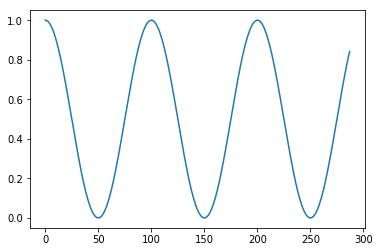

In [4]:
plt.plot(dataset)   
plt.show()

In [5]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 훈련은 0~10으로 테스트는 11로

look_back = param_window_size

trainX, trainY = create_dataset(dataset, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX, testY = create_dataset(dataset, look_back)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [7]:
%%time
theano.config.compute_test_value = "ignore"

# create and fit the LSTM network
batch_size = 1
model = Sequential()

for i in range(param_lstm_stack):
    model.add(LSTM(param_lstm_units, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(param_lstm_units, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

CPU times: user 973 ms, sys: 240 ms, total: 1.21 s
Wall time: 12.8 s


In [8]:
for epoch_idx in range(param_num_epoch):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=2, shuffle=False)
    model.reset_states()

epochs : 0
Epoch 1/1
2s - loss: 0.0408
epochs : 1
Epoch 1/1
2s - loss: 0.0487
epochs : 2
Epoch 1/1
2s - loss: 0.0163
epochs : 3
Epoch 1/1
2s - loss: 0.0270
epochs : 4
Epoch 1/1
2s - loss: 0.0144
epochs : 5
Epoch 1/1
2s - loss: 0.0097
epochs : 6
Epoch 1/1
2s - loss: 0.0087
epochs : 7
Epoch 1/1
2s - loss: 0.0072
epochs : 8
Epoch 1/1
2s - loss: 0.0067
epochs : 9
Epoch 1/1
2s - loss: 0.0075
epochs : 10
Epoch 1/1
2s - loss: 0.0065
epochs : 11
Epoch 1/1
2s - loss: 0.0072
epochs : 12
Epoch 1/1
2s - loss: 0.0071
epochs : 13
Epoch 1/1
2s - loss: 0.0068
epochs : 14
Epoch 1/1
2s - loss: 0.0068
epochs : 15
Epoch 1/1
2s - loss: 0.0051
epochs : 16
Epoch 1/1
2s - loss: 0.0045
epochs : 17
Epoch 1/1
2s - loss: 0.0053
epochs : 18
Epoch 1/1
2s - loss: 0.0048
epochs : 19
Epoch 1/1
2s - loss: 0.0058
epochs : 20
Epoch 1/1
2s - loss: 0.0067
epochs : 21
Epoch 1/1
2s - loss: 0.0064
epochs : 22
Epoch 1/1
2s - loss: 0.0059
epochs : 23
Epoch 1/1
2s - loss: 0.0064
epochs : 24
Epoch 1/1
2s - loss: 0.0062
epochs : 2

In [9]:
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

model.reset_states()

('Test Score: ', 0.0089356847361819567)


/Users/tykimos/Projects/Keras/venv/lib/python2.7/site-packages/matplotlib/animation.py:1021: UserWarning: MovieWriter imagemagick unavailable
  warnings.warn("MovieWriter %s unavailable" % writer)


ValueError: Cannot save animation: no writers are available. Please install ffmpeg to save animations.

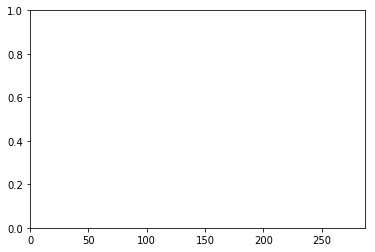

In [10]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 287), ylim=(0, 1))

plotcols = ["blue","red"]

lines = []

test_seq_size = param_seq_length - param_window_size
    
for i in range(2):
    lobj = ax.plot([],[],lw=1,color=plotcols[i])[0]
    lines.append(lobj)

def init():
    for line in lines:
        line.set_data([],[])
    return lines

def animate(curr_idx):

    predictions = np.zeros((test_seq_size, 1))
    testPredict = [np.vstack([testX[0][:]])]

    look_hist = curr_idx
    look_ahead = test_seq_size - curr_idx

    for i in range(look_hist):
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i] = testY[i]
        testPredict.append(np.vstack([testX[i+1][:]]))
        
    for i in range(look_ahead):    
        prediction = model.predict(np.array([testPredict[-1]]), batch_size=1)
        predictions[i + look_hist] = prediction
        testPredict.append(np.vstack([testPredict[-1][1:],prediction]))
    
    model.reset_states()
    
    x = np.linspace(0, test_seq_size-1, test_seq_size)
    y = [testY, predictions]
    
    #for index in range(0,1):
    for i, line in enumerate(lines):
        line.set_data(x, y[i]) # set data for each line separately. 

    return lines

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=test_seq_size, interval=20, blit=True)

result_filename = 'w' + str(param_window_size) + '_' + 'u' + str(param_lstm_units) + '_' + 's' + str(param_lstm_stack) + '_' + 'e' + str(param_num_epoch)

anim.save( result_filename + '.gif', writer='imagemagick', fps=30, dpi=100)

plt.show()